In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from xgboost import XGBClassifier, plot_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Function

In [80]:
df_clients_inc = pd.read_excel("nba_income.xlsx", sheet_name="ProcessedData")
df_clients_acc = pd.read_excel("nba_accumulation.xlsx", sheet_name="ProcessedData")
df_clients = pd.concat([df_clients_inc, df_clients_acc], axis=1)

df_needs = pd.read_excel("Dataset2_Needs.xls", sheet_name="Needs")
df_clients['RiskPropensity'] = df_needs['RiskPropensity'].values

df_products = pd.read_excel("Dataset2_Needs.xls", sheet_name="Products")

df_clients.head()

,reg_log_IncomeInvestment_proba,xgb_proba_IncomeInvestment,rf_proba_IncomeInvestment,mlp_proba_IncomeInvestment,Final_prediction_IncomeInvestment,reg_log_AccumulationInvestment_proba,xgb_proba_AccumulationInvestment,rf_proba_AccumulationInvestment,mlp_proba_AccumulationInvestment,Final_prediction_AccumulationInvestment,RiskPropensity
0,0.380486,0.213468,0.134143,0.218113,0,0.597279,0.957380,0.986431,0.937905,1,0.233355
1,0.666784,0.941034,0.982304,0.894990,1,0.190172,0.368105,0.129979,0.435538,0,0.170911
2,0.275250,0.170001,0.117212,0.210991,0,0.296254,0.386676,0.446670,0.249528,0,0.249703
3,0.815317,0.985981,1.000000,0.923227,1,0.725168,0.995153,1.000000,0.931942,1,0.654597
4,0.387887,0.198498,0.112653,0.195050,0,0.266550,0.382190,0.160914,0.273284,0,0.349039


In [81]:
# Générer la colonne 'final_case' si elle n'existe pas encore
def classify_case(row):
    income = row['Final_prediction_IncomeInvestment'].any()
    accumulation = row['Final_prediction_AccumulationInvestment'].any()

    if income == 1 and accumulation == 1:
        return '1-1'
    elif income == 0 and accumulation == 0:
        return '0-0'
    elif income == 1 and accumulation == 0:
        return '1-0'
    elif income == 0 and accumulation == 1:
        return '0-1'

# Appliquer à df_clients
df_clients['final_case'] = df_clients.apply(classify_case, axis=1)

def find_best_product(client_risk, filtered_products):
    product_ids = filtered_products['IDProduct'].values
    product_risks = filtered_products['Risk'].values

    suitable_products = filtered_products[product_risks < client_risk]

    if len(suitable_products) > 0:
        max_suitable_risk = suitable_products['Risk'].max()
        return suitable_products[suitable_products['Risk'] == max_suitable_risk]['IDProduct'].values[0]
    else:
        # Si aucun produit ne convient, proposer celui avec le risque le plus proche
        closest_idx = (abs(product_risks - client_risk)).argmin()
        return product_ids[closest_idx]

def recommend_products_to_clients(clients_df, products_df, case_label):
    target_client_ids = clients_df.index
    target_client_risk_propensity = clients_df['RiskPropensity'].values

    nba_recommendations = []

    if case_label == '0-0':
        print(f"❌ Aucun besoin identifié pour les clients '{case_label}', tous recevront 0.")
        return pd.Series(0, index=clients_df.index)

    elif case_label == '1-1':
        # Double recommandation : income + accumulation
        nba_recommendations_income = []
        nba_recommendations_accum = []

        products_income = products_df[products_df['Type'] == 0]
        products_accum = products_df[products_df['Type'] == 1]

        for client_risk in target_client_risk_propensity:
            income_id = find_best_product(client_risk, products_income)
            accum_id = find_best_product(client_risk, products_accum)
            nba_recommendations_income.append(income_id)
            nba_recommendations_accum.append(accum_id)

        # On retourne une colonne combinée "income-accum" (ex: 45|98)
        combined = [f"{inc}|{acc}" for inc, acc in zip(nba_recommendations_income, nba_recommendations_accum)]
        return pd.Series(combined, index=clients_df.index)

    else:
        product_type = 0 if case_label == '1-0' else 1
        filtered_products = products_df[products_df['Type'] == product_type]

        for client_risk in target_client_risk_propensity:
            prod_id = find_best_product(client_risk, filtered_products)
            nba_recommendations.append(prod_id)

        return pd.Series(nba_recommendations, index=clients_df.index)



# Regrouper les clients selon leur final_case
grouped_clients = {
    case: df_clients[df_clients['final_case'] == case].copy()
    for case in ['1-1', '1-0', '0-1', '0-0']
}

# Créer une colonne NBA vide
df_clients['nba'] = 0  # initialisation à 0 pour tous

# Appliquer les recommandations à chaque groupe
for case_label, clients_df in grouped_clients.items():
    print(f"\n📌 Traitement du cas : {case_label}")
    nba_column = recommend_products_to_clients(clients_df, df_products, case_label)
    df_clients.loc[nba_column.index, 'nba'] = nba_column



📌 Traitement du cas : 1-1


C:\Users\kevin\AppData\Local\Temp\ipykernel_26788\3732264776.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4|1' '4|5' '4|1' '2|9' '4|5' '2|9' '4|5' '4|5' '2|6' '10|9' '10|9' '4|1'
 '3|9' '2|6' '10|9' '10|9' '3|9' '4|8' '10|9' '3|9' '4|1' '4|1' '4|1'
 '10|9' '4|5' '10|9' '4|1' '2|6' '3|9' '2|6' '2|9' '2|5' '3|9' '4|5' '2|6'
 '2|5' '10|9' '2|9' '4|8' '4|1' '4|8' '4|1' '2|6' '4|1' '2|5' '10|9' '4|1'
 '2|6' '10|9' '10|9' '4|8' '4|1' '4|1' '4|1' '10|9' '2|5' '2|6' '4|1'
 '4|1' '3|9' '10|9' '2|6' '4|8' '4|1' '2|5' '10|9' '2|5' '4|8' '10|9'
 '4|8' '2|6' '4|1' '2|6' '10|9' '2|5' '4|1' '4|8' '4|8' '4|1' '2|9' '2|9'
 '2|6' '10|9' '2|5' '4|8' '2|5' '10|9' '2|6' '10|9' '2|6' '2|6' '4|8'
 '4|1' '3|9' '4|1' '2|9' '4|1' '4|1' '3|9' '2|6' '4|7' '2|9' '10|9' '2|6'
 '4|5' '10|9' '4|5' '2|6' '4|1' '10|9' '2|6' '4|1' '2|9' '2|6' '4|7' '4|1'
 '10|9' '2|9' '4|1' '4|5' '10|9' '4|1' '2|5' '4|7' '4|1' '2|6' '2|6' '4|8'



📌 Traitement du cas : 1-0

📌 Traitement du cas : 0-1

📌 Traitement du cas : 0-0
❌ Aucun besoin identifié pour les clients '0-0', tous recevront 0.


# Import Data

In [82]:
metadata_df = pd.DataFrame({
    'IDProduct': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Product description': [
        "Balanced Mutual Fund",
        "Income Conservative Unit-Linked (Life Insurance)",
        "Fixed Income Mutual Fund",
        "Balanced High Dividend Mutual Fund",
        "Balanced Mutual Fund",
        "Defensive Flexible Allocation Unit-Linked (Life Insurance)",
        "Aggressive Flexible Allocation Unit-Linked (Life Insurance)",
        "Balanced Flexible Allocation Unit-Linked (Life Insurance)",
        "Cautious Allocation Segregated Account",
        "Fixed Income Segregated Account",
        "Total Return Aggressive Allocation Segregated Account"
    ]
})

product_map = metadata_df.set_index('IDProduct')['Product description'].to_dict()

def map_product_description(nba_value):
    if nba_value == 0 or pd.isna(nba_value):
        return 'No Recommandation'
    elif isinstance(nba_value, str) and '|' in nba_value:
        # Cas "1-1" → double produit
        parts = nba_value.split('|')
        descs = [product_map.get(int(p), 'Unknown') for p in parts]
        return ' | '.join(descs)
    else:
        return product_map.get(int(nba_value), 'Unknown')

df_clients['nba_metadata'] = df_clients['nba'].apply(map_product_description)


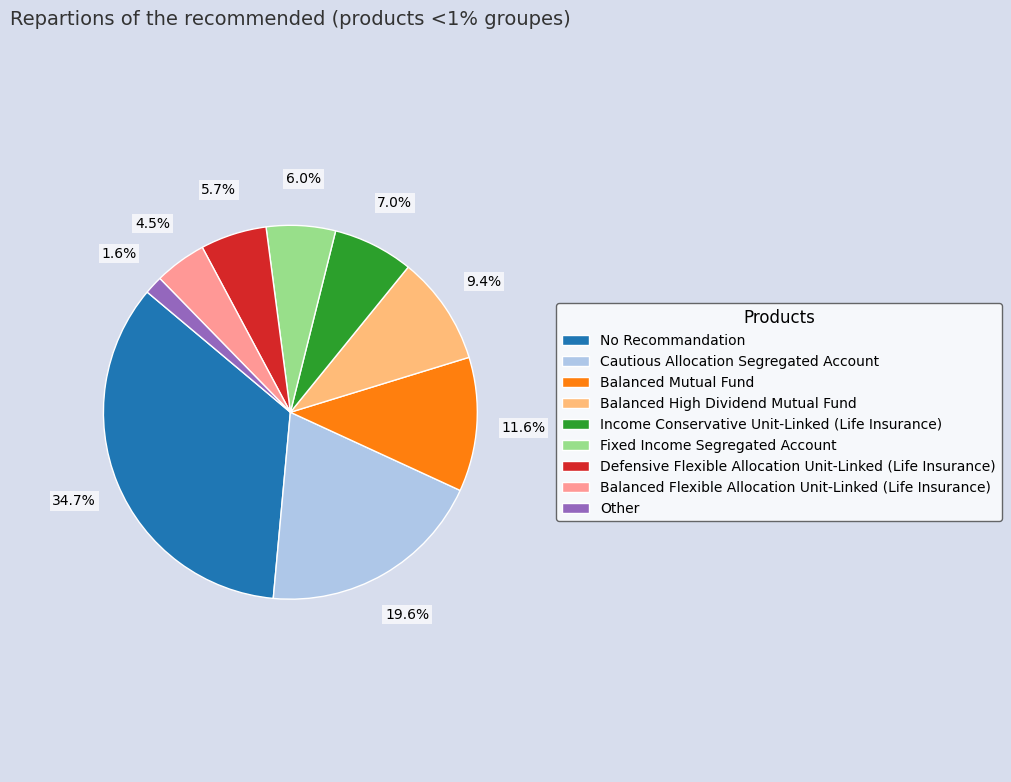

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Étape 1 : préparation des données
all_products = df_clients['nba_metadata'].copy()
all_products = all_products.str.split('|').explode().str.strip()
product_counts = all_products.value_counts()

# Calcul du pourcentage de chaque produit
total = product_counts.sum()
product_percent = product_counts / total * 100

# Étape 2 : regrouper les produits < 1% en "Other"
threshold = 2.0
main_products = product_percent[product_percent >= threshold]
other_products = product_percent[product_percent < threshold]

# Regrouper
grouped_counts = main_products.copy()
if len(other_products) > 0:
    grouped_counts['Other'] = other_products.sum()

# Étape 3 : génération du graphique
colors = plt.cm.tab20.colors[:len(grouped_counts)]

# Set up figure with custom background
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('#D7DDED')  # Apply background color to figure
ax.set_facecolor('#D7DDED')         # Apply background color to plot area

# Create pie chart
wedges, texts = ax.pie(
    grouped_counts,
    labels=None,
    startangle=140,
    colors=colors,
    wedgeprops=dict(edgecolor='white', linewidth=1),
    autopct=None
)

# Position percentages outside with contrast
for i, p in enumerate(wedges):
    angle = (p.theta2 + p.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    pct = grouped_counts.iloc[i]
    ax.text(
        x * 1.25, 
        y * 1.25, 
        f"{pct:.1f}%", 
        ha='center', 
        va='center', 
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)  # White background for readability
    )

# Customized legend
legend = ax.legend(
    wedges,
    grouped_counts.index,
    title="Products",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    facecolor='white',  # Legend background
    edgecolor='#444444'
)

# Styled title
ax.set_title(
    "Repartions of the recommended (products <1% groupes)", 
    fontsize=14,
    pad=20,  # Add padding
    color='#333333'  # Dark gray for contrast
)

plt.axis('equal')
plt.tight_layout()
plt.show()


In [84]:
product_count_df = product_counts.reset_index()
product_count_df.columns = ['ProductName', 'Count']
display(product_count_df)

,ProductName,Count
0,No Recommandation,1972
1,Cautious Allocation Segregated Account,1115
2,Balanced Mutual Fund,661
3,Balanced High Dividend Mutual Fund,535
4,Income Conservative Unit-Linked (Life Insurance),396
5,Fixed Income Segregated Account,340
6,Defensive Flexible Allocation Unit-Linked (Lif...,326
7,Balanced Flexible Allocation Unit-Linked (Life...,256
8,Fixed Income Mutual Fund,65
9,Aggressive Flexible Allocation Unit-Linked (Li...,24


In [85]:
df_clients_inc

,reg_log_IncomeInvestment_proba,xgb_proba_IncomeInvestment,rf_proba_IncomeInvestment,mlp_proba_IncomeInvestment,Final_prediction_IncomeInvestment
0,0.380486,0.213468,0.134143,0.218113,0
1,0.666784,0.941034,0.982304,0.894990,1
2,0.275250,0.170001,0.117212,0.210991,0
3,0.815317,0.985981,1.000000,0.923227,1
4,0.387887,0.198498,0.112653,0.195050,0
...,...,...,...,...,...
4995,0.394181,0.169096,0.184990,0.187530,0
4996,0.626900,0.300813,0.187929,0.752641,0
4997,0.390009,0.203084,0.054897,0.226945,0
4998,0.441528,0.259714,0.258517,0.350861,0


In [86]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df_clients = pd.read_excel("df_income.xlsx", sheet_name="ProcessedData")
X1 = df_clients[["Age",	"FinancialEducation", "RiskPropensity",	"Income", "Wealth",	"Wealth / Income",	"FinancialEducation * RiskPropensity", "RiskPropensity * Income",	"IncomeInvestment"]]
y1 = df_clients['IncomeInvestment']

target1 = 'IncomeInvestment'
y = df_clients[[target1]]  
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

print(f"\n📊 Évaluation sur TEST SET : Final_prediction_{target1}")
print("=" * 60)

y_true = y_test[target1]
y_pred = df_clients_inc.loc[X_test.index, f'Final_prediction_{target1}']

print("🧾 Classification Report :")
print(classification_report(y_true, y_pred))


# Optionnel : ROC AUC si proba dispo
y_proba = (df_clients_inc["reg_log_IncomeInvestment_proba"] + df_clients_inc["xgb_proba_IncomeInvestment"] + df_clients_inc["rf_proba_IncomeInvestment"] + df_clients_inc["mlp_proba_IncomeInvestment"]) / 3
print(f"🎯 ROC AUC Score : {roc_auc_score(y_true, y_proba):.4f}")

df_clients = pd.read_excel("df_accumulation.xlsx", sheet_name="ProcessedData")
X2 = df_clients[["Age", "FinancialEducation", "Income", "Wealth"]]
y2 = df_clients[ 'AccumulationInvestment']

target2 = 'AccumulationInvestment'
y = df_clients[[target2]] 
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

print(f"\n📊 Évaluation sur TEST SET : Final_prediction_{target2}")
print("=" * 60)

y_true = y_test[target2]
y_pred = df_clients_acc.loc[X_test.index, f'Final_prediction_{target2}']

print("🧾 Classification Report :")
print(classification_report(y_true, y_pred))

    

# Optionnel : ROC AUC si proba dispo
proba_cols = [f'{model}_proba_{target2}' for model in ['reg_log', 'xgb', 'rf', 'mlp']]
available_cols = [col for col in proba_cols if col in df_clients.columns]

y_proba = df_clients.loc[X_test.index, available_cols].mean(axis=1)
print(f"🎯 ROC AUC Score : {roc_auc_score(y_true, y_proba):.4f}")


📊 Évaluation sur TEST SET : Final_prediction_IncomeInvestment
🧾 Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       619
           1       0.87      0.60      0.71       381

    accuracy                           0.81      1000
   macro avg       0.83      0.77      0.79      1000
weighted avg       0.82      0.81      0.81      1000



ValueError: Found input variables with inconsistent numbers of samples: [1000, 5000]

In [ ]:
print((df_clients_inc["reg_log_IncomeInvestment_proba"] + df_clients_inc["xgb_proba_IncomeInvestment"] + df_clients_inc["rf_proba_IncomeInvestment"] + df_clients_inc["mlp_proba_IncomeInvestment"]) / 3)

0       0.315403
1       1.161704
2       0.257818
3       1.241508
4       0.298030
          ...   
4995    0.311932
4996    0.622761
4997    0.291645
4998    0.436874
4999    0.852174
Length: 5000, dtype: float64
